# Adaptive Variational Quantum Dynamics of Heisenberg model

In [1]:
import numpy as np
import os
import sys
import time
from model import zzxzmodel
from model import heis
from ansatz import ansatz
from avaridyn import avaridynIsing
from avaridyn import avaridynHeis
from ansatz import generate_op_pools
from qiskit import QuantumCircuit, QuantumRegister, execute
from qiskit.opflow import Zero, One, I, X, Y, Z

## The initial setup

In [2]:
N=3 # The system size


start = time.time() 


nsite = N

# init_state = ([state for supersposition],[phase]) : phase e^(i\phi)
init_state_1 = ([0,4,6,7],[1,1,1,1]) #Create initial state 0-> [down,down,down], 1-> [up,down,down].....

# Make initial state at ref_state at t=0
ref_state = np.zeros((2**nsite),dtype=complex)

if len(init_state_1[0])==1:
    
    ref_state[init_state_1[0][0]] = 1
    
else:
    
    for i in range(len(init_state_1[0])):
        
        ref_state[init_state_1[0][i]]=init_state_1[1][i]/np.sqrt(len(init_state_1[0]))

## Build the model and run AVQDS for the model

In [3]:
ans = ansatz(nsite, ref_state = ref_state, pool='Heis', pthcut=9000) # Create Heisenberg operator pool: Rzz, Rxx, Ryy

# builds up the Hamiltonian model (see model.py)
model = heis(nsite=nsite, T=np.pi/4, Jzz_init = np.ones(nsite), Jxx_init= np.zeros(nsite), Jyy_init = np.zeros(nsite), hs_init = np.zeros(nsite), Jxx=1.0, Jyy=1.0, Jzz=1.0)
# T: the total evolution time. If one wan to get U(\pi/4), one can set it as np.pi/4


# The set up for time evolution with Hamiltonian
dyn = avaridynHeis(model, ans, quench_type = 1, init_state = init_state_1, dtmax=0.001, dthmax=0.01) 

dyn.run() # Run avqds simulator to find best parameters and operators for pseudo-Trotter time evolution. 
# (also save the file named as params_trace.dat and ansatz.h5)

## Search Corresponding Variational Parameters at t=$\pi/4$

In [5]:
target_t=np.pi/4 # the evolution time we want to get. If one wan to get U(\pi/4), one can set it as np.pi/4
f = open("params_trace.dat", "r") # open the variational parameters file
num_string = f.readline()
pi_closer = 0
del_num = 1000
while num_string != '': 
    num = num_string.split()
    time = float(num[0])

    if min(del_num,np.abs(time-target_t))==del_num:
        pass
    else:
        del_num=np.abs(time-target_t)
        pi_closer=time
        params=num[1:]
    num_string = f.readline()

print(params) # The variational parameters

['1.568558894570', '-0.589304086882', '1.064723944699', '1.844518631645', '1.077702366031', '1.813238275226', '1.569016517852', '1.005516641164', '1.844651840316', '1.067741705628', '-0.589040551056']


In [6]:
for i in range(len(params)):
    print('The '+str(i)+'th variational parameter are:', round(float(params[i]),4))
    
    if ans._ansatz[1][i][1] == 1:
    
        print('The corresponding Operator is XX('+str(ans._ansatz[1][i][0])+','+str(ans._ansatz[1][i][2])+')')
    
    elif ans._ansatz[1][i][1] == 2:
        
        print('The corresponding Operator is YY('+str(ans._ansatz[1][i][0])+','+str(ans._ansatz[1][i][2])+')')
        
    elif ans._ansatz[1][i][1] == 3:
        
        print('The corresponding Operator is ZZ('+str(ans._ansatz[1][i][0])+','+str(ans._ansatz[1][i][2])+')')

The 0th variational parameter are: 1.5686
The corresponding Operator is ZZ(0,1)
The 1th variational parameter are: -0.5893
The corresponding Operator is ZZ(1,2)
The 2th variational parameter are: 1.0647
The corresponding Operator is XX(0,1)
The 3th variational parameter are: 1.8445
The corresponding Operator is YY(0,1)
The 4th variational parameter are: 1.0777
The corresponding Operator is XX(1,2)
The 5th variational parameter are: 1.8132
The corresponding Operator is YY(1,2)
The 6th variational parameter are: 1.569
The corresponding Operator is ZZ(0,1)
The 7th variational parameter are: 1.0055
The corresponding Operator is ZZ(1,2)
The 8th variational parameter are: 1.8447
The corresponding Operator is YY(0,1)
The 9th variational parameter are: 1.0677
The corresponding Operator is XX(0,1)
The 10th variational parameter are: -0.589
The corresponding Operator is ZZ(1,2)


## Create the Quantum Variational Circuit

In [7]:
qc = QuantumCircuit(nsite) # create quantum circuit
qc.x([1,2])
for _ in range(4): # if one want to repeat 4 times, set it as 4
    for i,op in enumerate(ans._ansatz[1]):
        if op[1]==3:                             # op[1]=3: means Rzz gate
            qc.rzz(float(params[i]),op[0],op[2])
        elif op[1]==2:                           # op[1]=2: means Ryy gate
            qc.ryy(float(params[i]),op[0],op[2])
        elif op[1]==1:                           # # op[1]=1: means Rxx gate
            qc.rxx(float(params[i]),op[0],op[2])

## State Tomography Test on Simulator

In [8]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import state_fidelity
import warnings
warnings.filterwarnings('ignore')

In [9]:
st_qcs = state_tomography_circuits(qc,[0,1,2]) # create circuits for state tomography
backend = QasmSimulator(method='statevector')

In [10]:
reps=4
jobs = []
shots=8192
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots)
    jobs.append(job)

In [11]:
def state_tomo(result, st_qcs): #, time):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    initial_state = One^One^Zero

    tomo_fitter = StateTomographyFitter(result, st_qcs)

    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [12]:
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)#, target_time)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.9960 ± 0.0005



# Quantum Simulation

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

import qiskit

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
import math
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [15]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

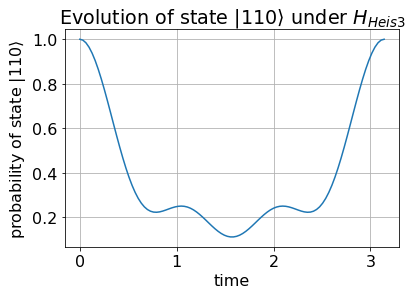

In [16]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

# Run on the Real device

In [17]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Qiskit Pulse imports
import qiskit.pulse
from qiskit import pulse
from qiskit.pulse import library

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag

from scipy.special import erf

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [18]:
# load IBMQ Account data
IBMQ.save_account('',overwrite=True )
IBMQ.load_account()

# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
#provider = IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [19]:

provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

backend  = provider.get_backend('ibmq_jakarta')

properties = backend.properties()

In [ ]:
# The PassManager helps decide how a circuit should be optimized
# (https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html)
from qiskit.transpiler import PassManager

# This function will pull pulse-level calibration values to build RZX gates and tell the PassManager to leave RZX gates alone
from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho

## Rzz gate using qiskit's non echo Rzx

In [ ]:
def rzz_qiskit(qc,angle,q1,q0): # Using non-echo Rzx gate to create Rzz gate 
    qc.ry(-np.pi/2,q0)
    qc.rzx(angle/2, q1, q0) # non-echo Rzx gate
    qc.x(q1) # X \pi echo pulse
    qc.rzx(-angle/2, q1, q0) # non-echo Rzx gate
    qc.x(q1)
    qc.ry(np.pi/2,q0)

## Setup the Quantum Circuits

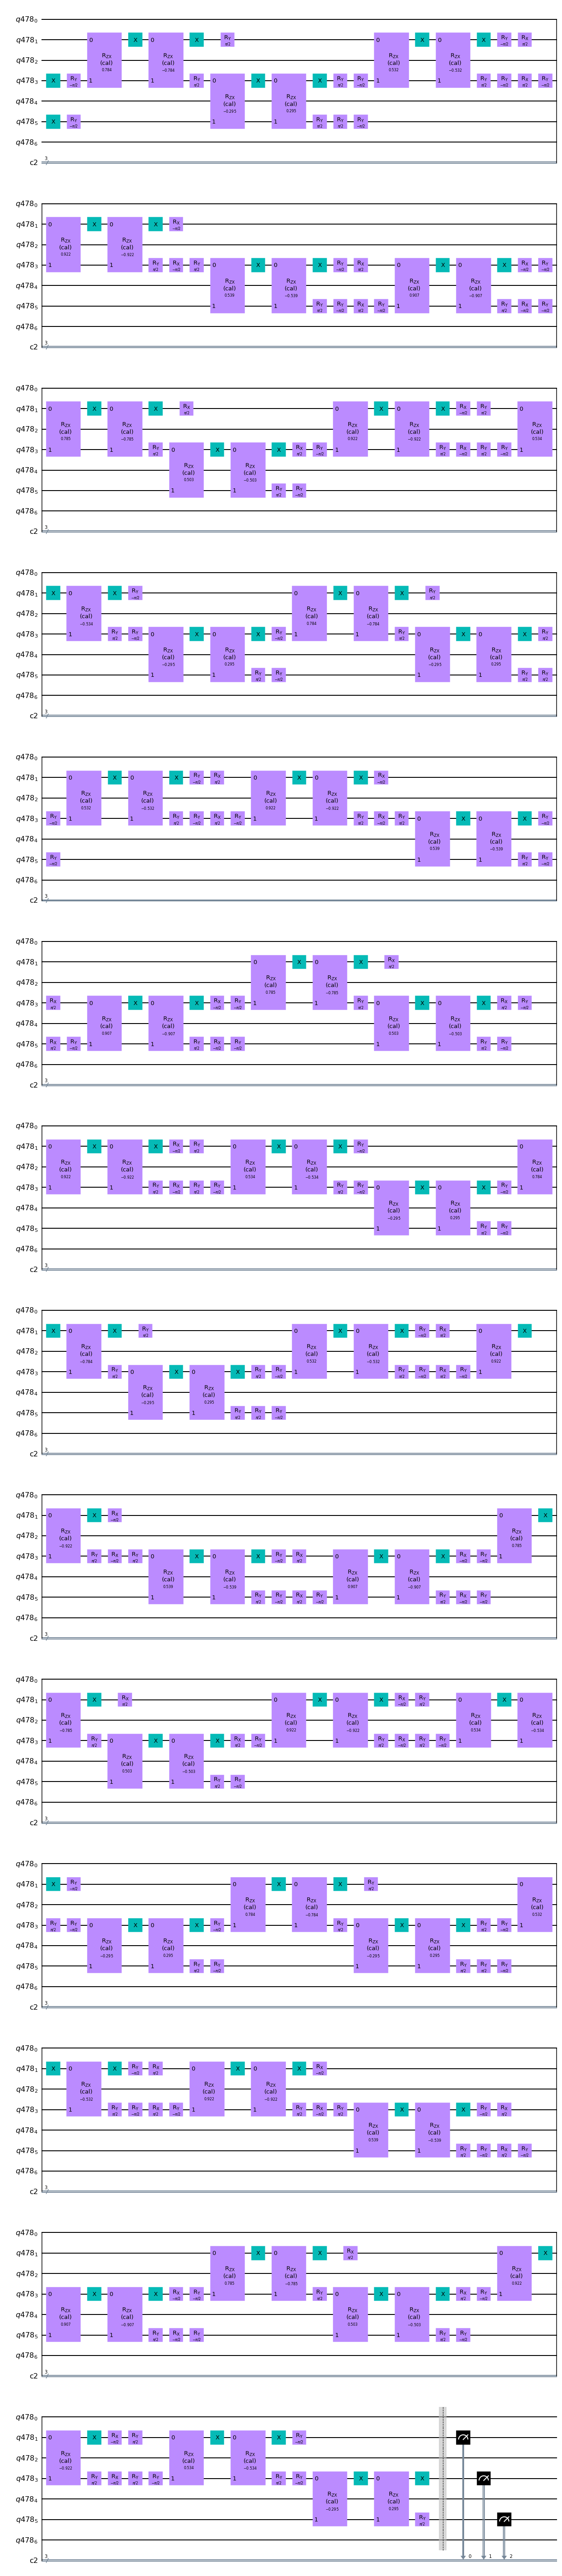

In [ ]:
target_time = np.pi 

target_t=np.pi/4 # the evolution time we want to get 
f = open("params_trace.dat", "r") # open the variational parameters file
num_string = f.readline()
pi_closer = 0
del_num = 1000
while num_string != '': # find out variational parameters when t=target_t
    num = num_string.split()
    time = float(num[0])
    if min(del_num,np.abs(time-target_t))==del_num:
        pass
    else:
        del_num=np.abs(time-target_t)
        pi_closer=time
        params=num[1:]
    num_string = f.readline()


# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

qlst=[1,3,5]

q0=qlst[0]

q1=qlst[1]

q2=qlst[2]

for _ in range(4): # Repeat 4 times which satisfies the rule 4 trotter steps
    for i,op in enumerate(ans._ansatz[1]):
        if op[1]==3:
          # op[1]=3: means Rzz gate
            rzz_qiskit(qc,float(params[i]),qlst[op[0]],qlst[op[2]])
        elif op[1]==2:
          # op[1]=2: means Ryy gate
            qc.rx(np.pi/2,[qlst[op[0]],qlst[op[2]]])
            rzz_qiskit(qc,float(params[i]),qlst[op[0]],qlst[op[2]])
            qc.rx(-np.pi/2,[qlst[op[0]],qlst[op[2]]])
        elif op[1]==1:
          # # op[1]=1: means Rxx gate
            qc.ry(np.pi/2,[qlst[op[0]],qlst[op[2]]])
            rzz_qiskit(qc,float(params[i]),qlst[op[0]],qlst[op[2]])
            qc.ry(-np.pi/2,[qlst[op[0]],qlst[op[2]]])
            

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#qc = qc.bind_parameters({t: target_time/trotter_steps})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[q0], qr[q1], qr[q2]])

pm = PassManager([RZXCalibrationBuilderNoEcho(backend)])
st_qcs_pulse_efficient = pm.run(st_qcs)
st_qcs_pulse_efficient[-1].draw('mpl') # optimized the pulse sequence


## Dynamical decoupling

In [ ]:
def DD_circuit_qiskit_pulse(circuit, backend, qubits_list, initial_layout = None, name=False):
    """

    Dynamical decoupling X_\pi-X_-\pi 


    circuit: qiskit circuit

    backend: ibm device

    qubits_list: the qubit list used to run 

    name: 'the circuit name'

    """

    if initial_layout:

        circuit = transpile(circuit, backend, scheduling_method='asap',initial_layout =init_layout)

    else:

        circuit = transpile(circuit, backend, scheduling_method='asap')

    if name:

        DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs,name=circuit.name)

    else:

        DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs)

    for operation in circuit[:]:

        if type(operation[0])==qiskit.circuit.delay.Delay:

            if  operation[0].duration >= 400:

                q_index = operation[1][0].index

                if q_index in qubits_list:

                    t=(operation[0].duration-320)//4 

                    t = math.ceil((t)/16)*16 # must be the multiple of 16

                    DD_cir.delay(t,[q_index],'dt')

                    DD_cir.x(q_index) # X_\pi

                    DD_cir.delay(2*t,[q_index],'dt')

                    DD_cir.z(q_index) # Z gate won't contribute time in ibm device

                    DD_cir.x(q_index) # X_-\pi

                    DD_cir.z(q_index) # Z gate won't contribute time in ibm device

                else:

                    DD_cir.data.append(operation)

            else:

                DD_cir.data.append(operation)

        else:

            DD_cir.data.append(operation)

    pm = PassManager([RZXCalibrationBuilderNoEcho(backend)])
    DD_cir_pulse_efficient = pm.run(DD_cir)

    return DD_cir_pulse_efficient

In [ ]:
from qiskit import *

In [ ]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [ ]:
qubits_list = [1,3,5]

cirs=[]

# create the circuits w/ dynamical decoupling.
for i in range(len(st_qcs)):

    cir_pulse_efficient=DD_circuit_qiskit_pulse(st_qcs_pulse_efficient[i], backend, qubits_list, name=True )

    cirs.append(cir_pulse_efficient)

## Readout Error Mitigation 

In [ ]:
# Using complete readout error mitigation
qubits_list = [q0,q1,q2]

shots=8192

qr = QuantumRegister(len(qubits_list),'q')

meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [ ]:
# Execute the readout error mitigation circuits first
init_layout = {}

for i,j in enumerate(qubits_list):

    init_layout[qr[i]] = j

cal_results = execute(meas_calibs, backend, shots=shots, initial_layout=init_layout)

print('Job ID', cal_results.job_id())

Job ID 624cdbe0aacb9bea725f4128


In [ ]:
shots = 8192
reps =8
#backend = sim_noisy_jakarta
# reps = 8
backend = backend #jakarta

jobs = []
for _ in range(reps):
    # execute state tomography circuits
    job = execute(cirs, backend, shots=shots)

    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 624cdbe6aacb9b0bb15f4129
Job ID 624cdbeb4b515275f37c5db0
Job ID 624cdbf1d72033ca6d67cb5a
Job ID 624cdbf7d720338d8867cb5b


In [ ]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job is queued (501)

## Job Retrieve

In [ ]:
# The history result


# Readout error mitigation result
cal_results=backend.retrieve_job('624cdbe0aacb9bea725f4128')

# State tomography result
ids=['624cdbe6aacb9b0bb15f4129','624cdbeb4b515275f37c5db0','624cdbf1d72033ca6d67cb5a','624cdbf7d720338d8867cb5b']
jobs=[]
for id in ids:
    jobs.append(backend.retrieve_job(id))

## Result

In [ ]:
meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels)

meas_filter = meas_fitter.filter

In [ ]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs): #, time):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    initial_state = One^One^Zero

    #target_state = (U_heis3(float(time)) @ initial_state).eval().to_matrix()

    mit_result = meas_fitter.filter.apply(result)

    tomo_fitter = StateTomographyFitter(mit_result, st_qcs)

    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition

fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.7044 ± 0.0084


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table